In [2]:
import os
import caer
import canaro
import tensorflow, keras
import numpy as np
import cv2 as cv
import gc

In [3]:
IMG_SIZE = (80,80)
channels = 1
char_path = r'../GOT/dataset/train'

In [4]:
# Creating a character dictionary, sorting it in descending order
char_dict = {}
for char in os.listdir(char_path):
    char_dict[char] = len(os.listdir(os.path.join(char_path,char)))

# Sort in descending order
char_dict = caer.sort_dict(char_dict, descending=True)
char_dict

[('sansa', 103),
 ('arya', 97),
 ('cersie', 81),
 ('ned stark', 73),
 ('danerys', 70),
 ('Jaimie', 63),
 ('Tyrion', 63),
 ('peter baelish', 57),
 ('john', 56)]

In [5]:
#  Getting the first 10 categories with the most number of images
characters = []
count = 0
for i in char_dict:
    characters.append(i[0])
    count += 1
    if count >= 10:
        break
characters

['sansa',
 'arya',
 'cersie',
 'ned stark',
 'danerys',
 'Jaimie',
 'Tyrion',
 'peter baelish',
 'john']

In [6]:
# Create the training data
train = caer.preprocess_from_dir(char_path, characters, channels=channels, IMG_SIZE=IMG_SIZE, isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] 103 files found in 0.0039055347442626953s
[INFO] 97 files found in 0.0s
[INFO] 81 files found in 0.0s
[INFO] 73 files found in 0.00249481201171875s
[INFO] 70 files found in 0.0012803077697753906s
[INFO] 63 files found in 0.0012593269348144531s
[INFO] 63 files found in 0.0s
[INFO] 57 files found in 0.0005028247833251953s
[INFO] 56 files found in 0.0014560222625732422s
----------------------------------------------
[INFO] 663 files preprocessed! Took 0m 6s


In [7]:
# Number of training samples
len(train)

663

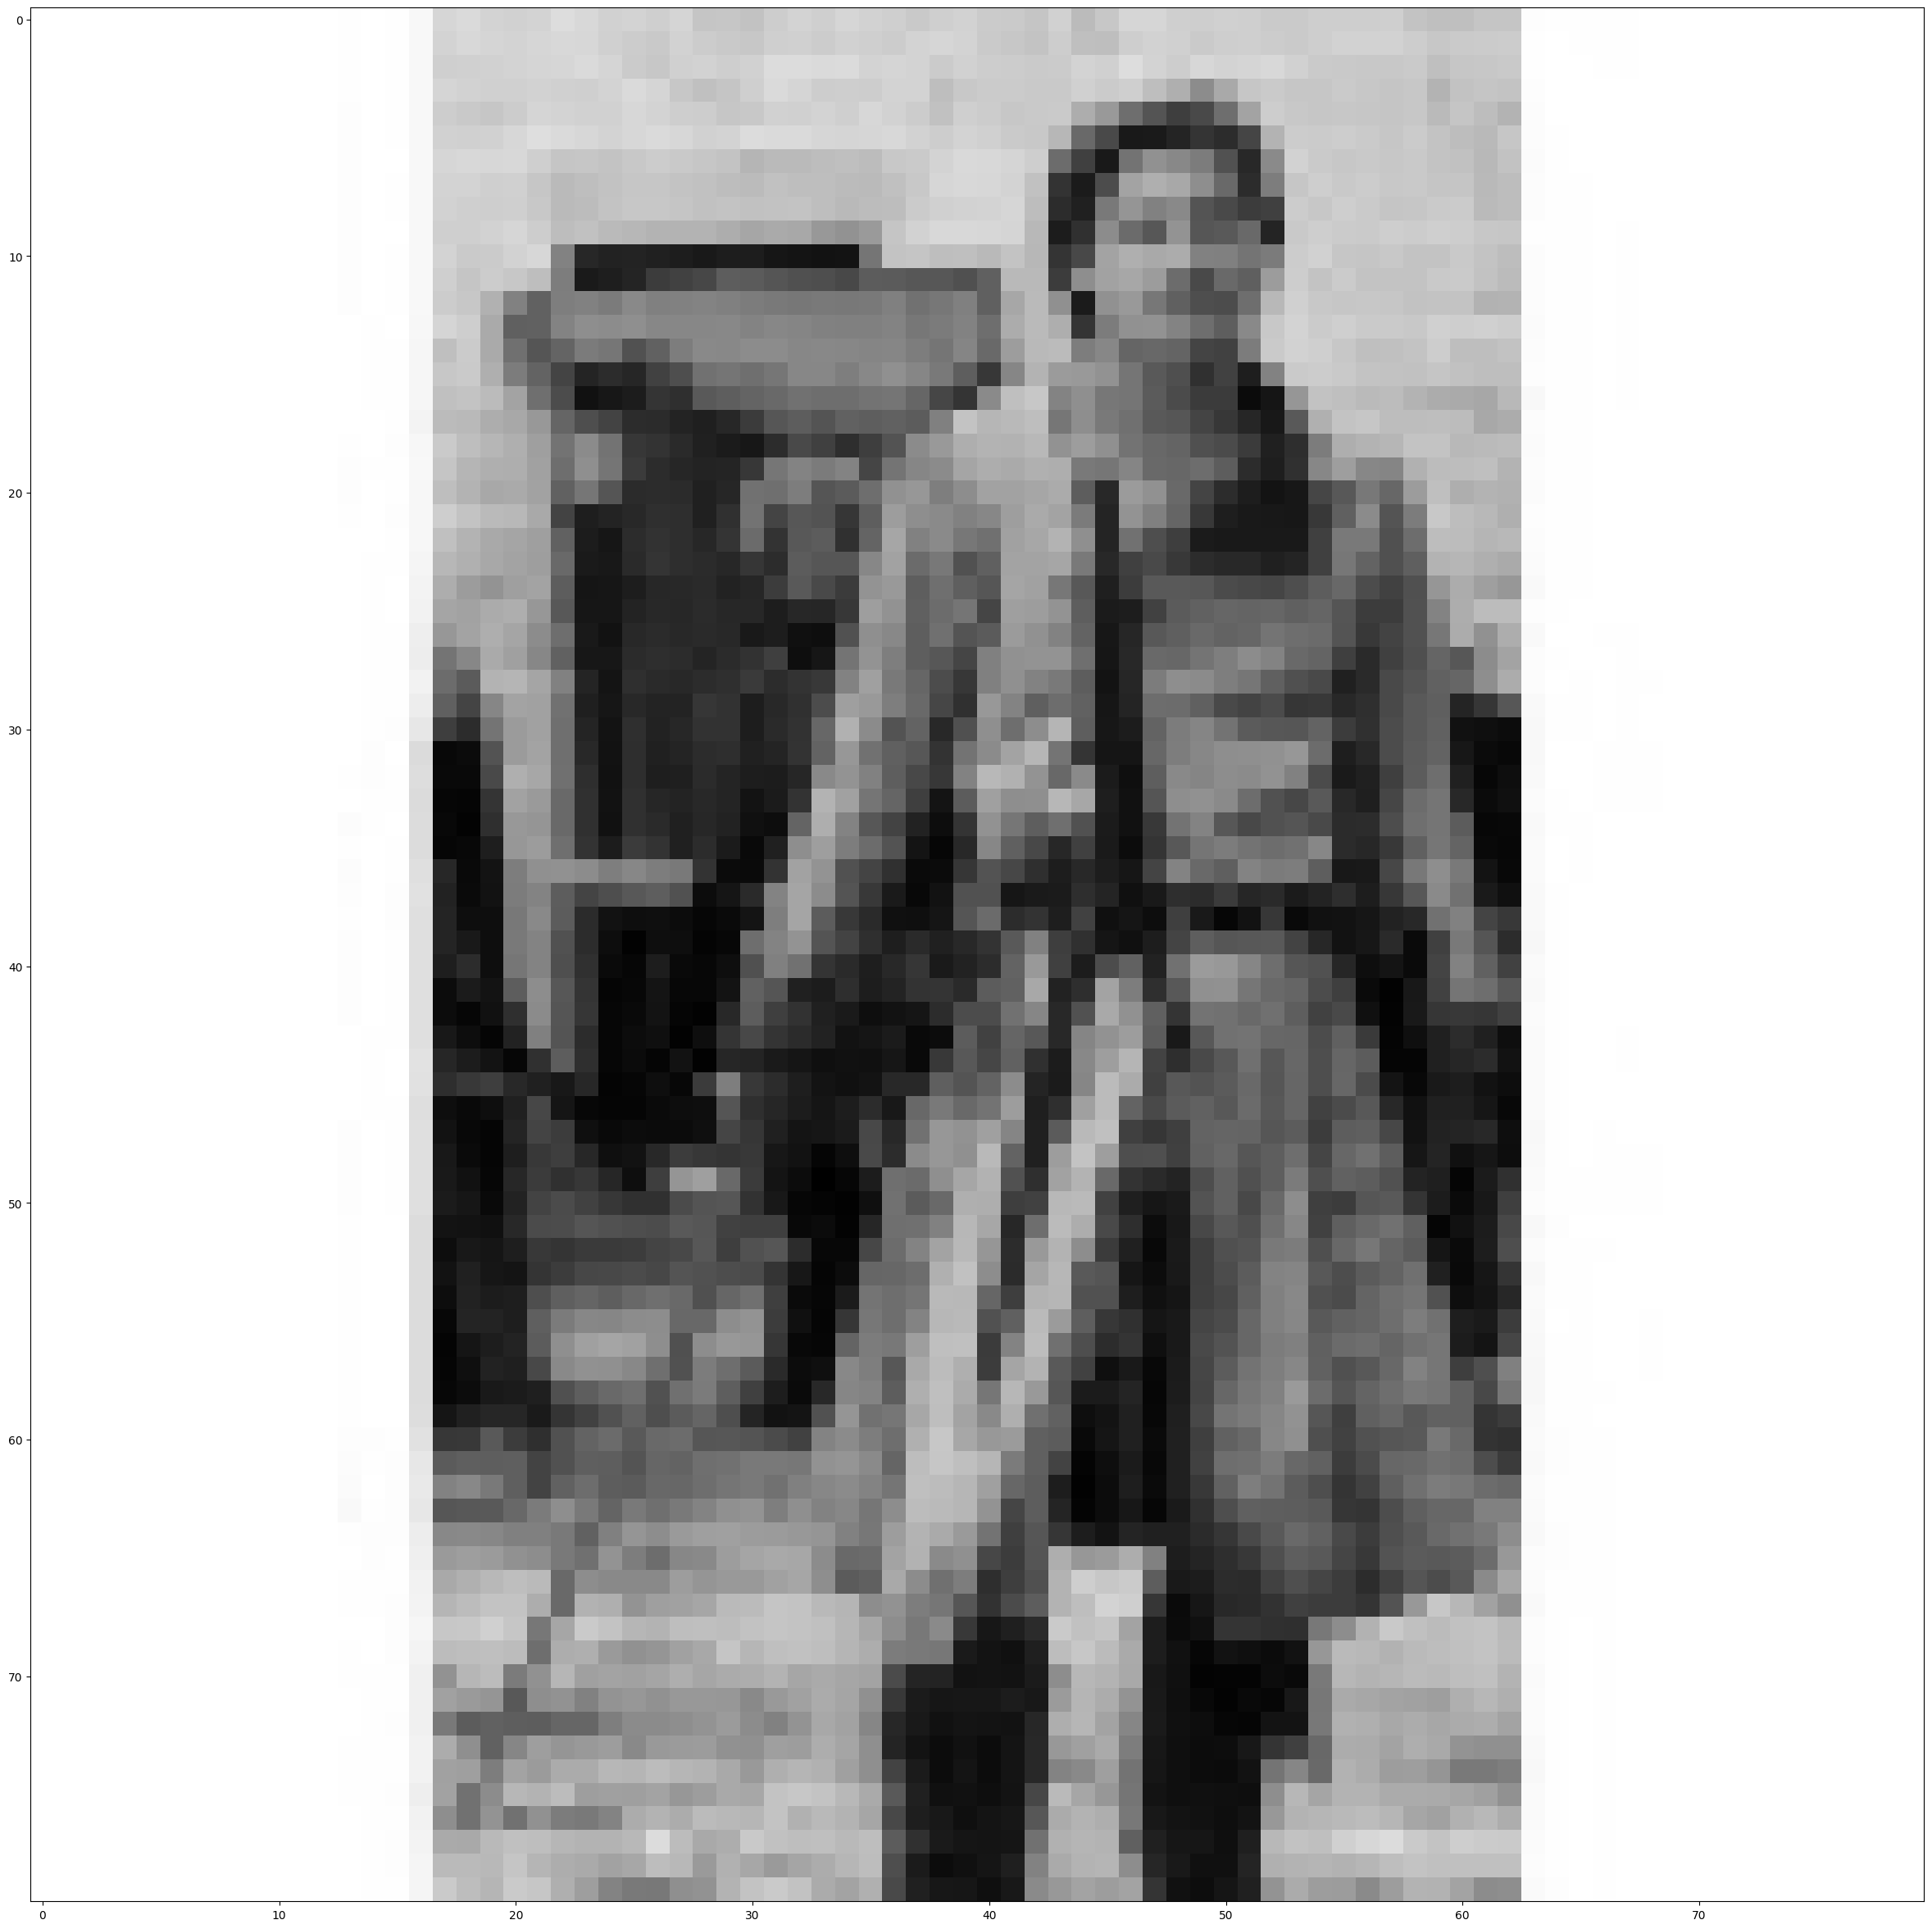

In [8]:
# Visualizing the data (OpenCV doesn't display well in Jupyter notebooks)
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
plt.imshow(train[0][0], cmap='gray')
plt.show()

In [9]:
# Separating the array and corresponding labels
featureSet, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)

In [10]:
from tensorflow.keras.utils import to_categorical

# Normalize the featureSet ==> (0,1)
featureSet = caer.normalize(featureSet)
# Converting numerical labels to binary class vectors
labels = to_categorical(labels, len(characters))

In [ ]:
x_train, x_val, y_train, y_val = caer.train_val_split(featureSet, labels, val_ratio=.2)

In [ ]:
del train
del featureSet
del labels 
gc.collect()

In [ ]:
# Useful variables when training
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
# Image data generator (introduces randomness in network ==> better accuracy)
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [ ]:
# Create our model (returns a compiled model)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D

output_dim=10

w, h = IMG_SIZE[:2]

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(w, h,channels)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu')) 
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))

# Output Layer
model.add(Dense(output_dim, activation='softmax'))


In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.optimizers.legacy import SGD
optimizer = SGD(learning_rate=0.001, decay=1e-7, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# Training the model

from tensorflow.keras.callbacks import LearningRateScheduler
callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]
training = model.fit(train_gen,
                    steps_per_epoch=len(x_train)//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    validation_steps=len(y_val)//BATCH_SIZE,
                    callbacks = callbacks_list)

In [ ]:
characters

Testing

In [ ]:
test_path = r'../GOT/dataset/test/Jaimie/image23.jpg'

img = cv.imread(test_path)

plt.imshow(img)
plt.show()

In [ ]:
def prepare(image):
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = cv.resize(image, IMG_SIZE)
    image = caer.reshape(image, IMG_SIZE, 1)
    return image

In [ ]:
predictions = model.predict(prepare(img))

In [ ]:
# Getting class with the highest probability
print(characters[np.argmax(predictions[0])])